In [1]:
!pip install tensorflow_hub

In [2]:
!pip install opencv_python==4.2.0.34

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
model = tf.keras.Sequential([
    hub.KerasLayer(handle=url, input_shape=(224,224,3), trainable=False)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [4]:
import pathlib

data_root = pathlib.Path('./Downloads/imagenetv2-top-images-format-val/')
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

Downloads/imagenetv2-top-images-format-val/797
Downloads/imagenetv2-top-images-format-val/909
Downloads/imagenetv2-top-images-format-val/135
Downloads/imagenetv2-top-images-format-val/307
Downloads/imagenetv2-top-images-format-val/763
Downloads/imagenetv2-top-images-format-val/551
Downloads/imagenetv2-top-images-format-val/61
Downloads/imagenetv2-top-images-format-val/95
Downloads/imagenetv2-top-images-format-val/338
Downloads/imagenetv2-top-images-format-val/936


In [5]:
label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
label_file = tf.keras.utils.get_file('label', label_url)
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


In [6]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count : ', image_count)

image_count :  10000


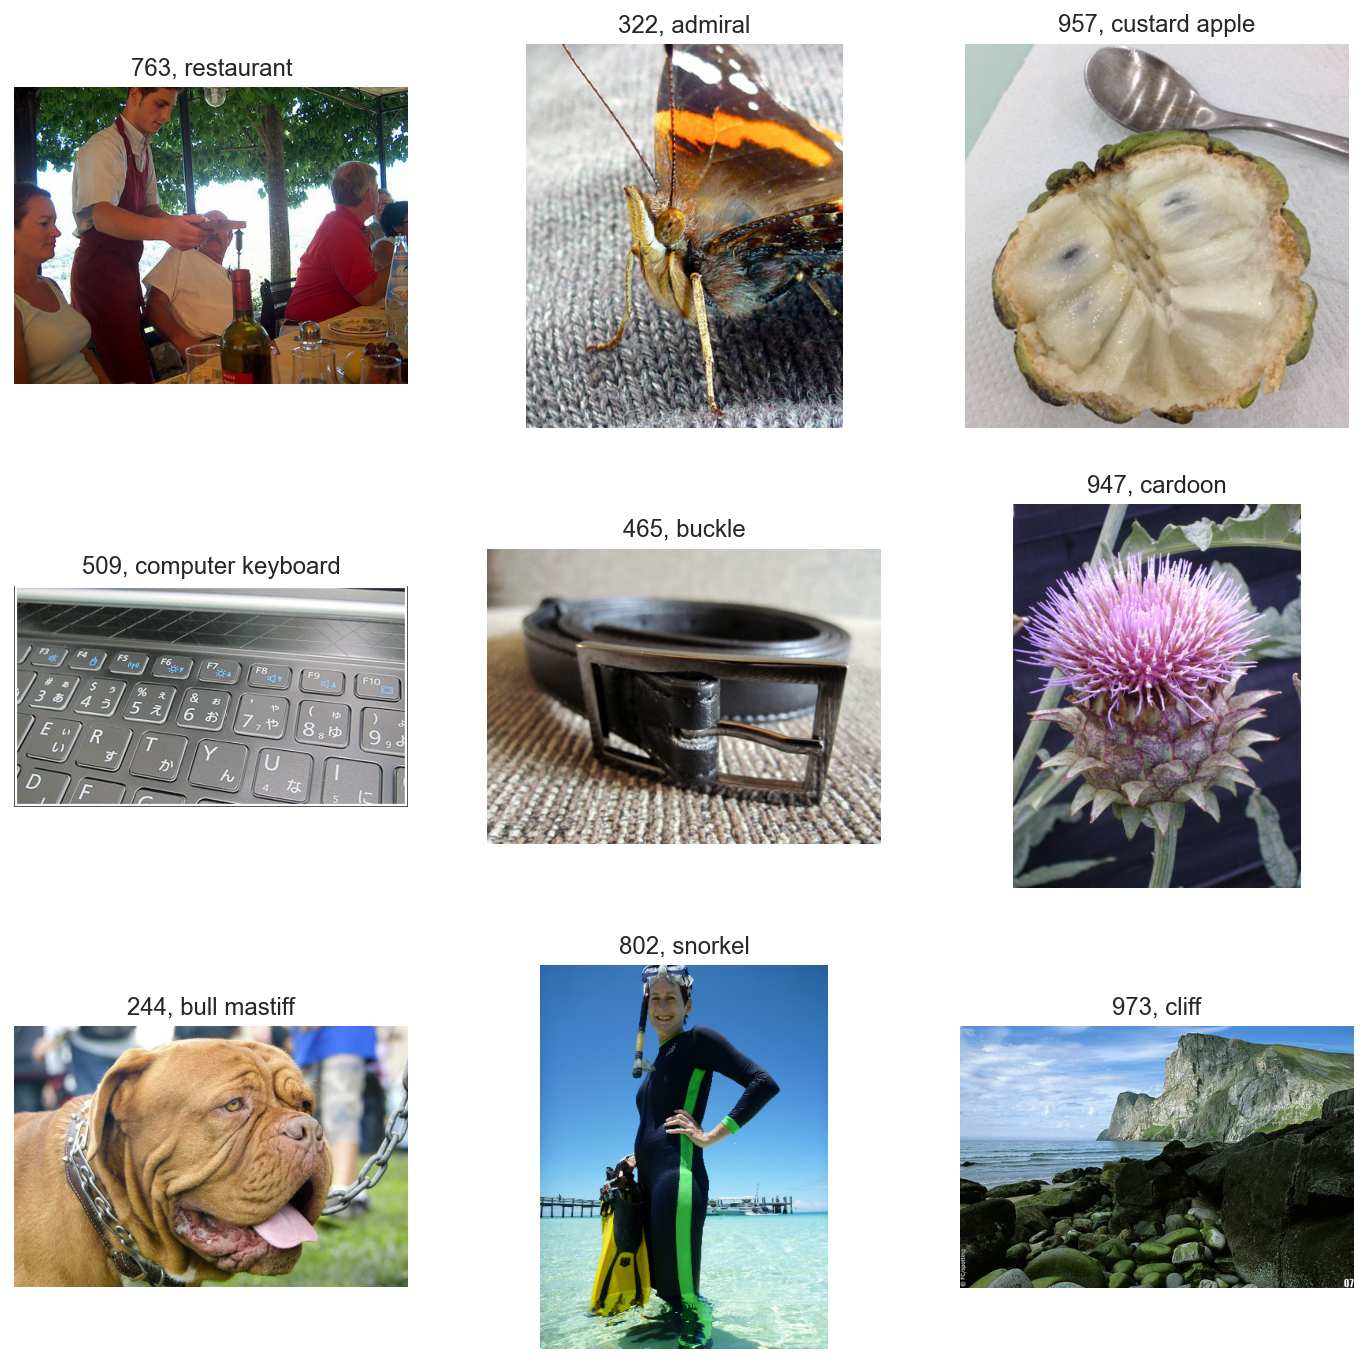

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
plt.show()

[901 823 427 418 542]
901
Anser is correct !!
Predicted Answer is  water tower


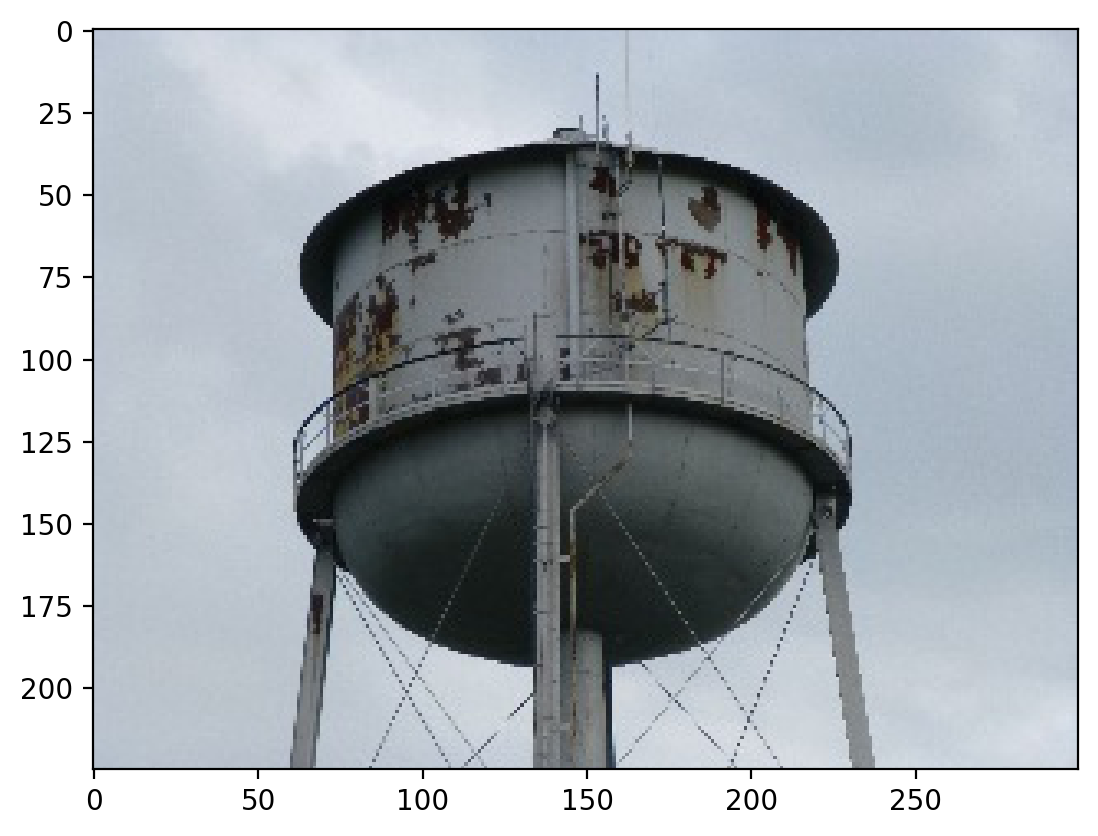

In [8]:
import cv2
import random
plt.style.use('default')

img = random.choice(all_image_paths)
label = int(img.split('/')[-2])+1
img_draw = cv2.imread(img)
img_resized = cv2.resize(img_draw, dsize=(224,224))
img_resized = img_resized / 255.0
img_resized = np.expand_dims(img_resized, axis=0)
top_5_predict = model.predict(img_resized)[0].argsort()[::-1][:5]
print(top_5_predict)
print(label)
if label in top_5_predict:
    print('Anser is correct !!')
print('Predicted Answer is ', label_text[label])

plt.imshow(plt.imread(img));

In [9]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

logits = model.predict(img_resized)[0]
prediction = softmax(logits)

top_5_predict = prediction.argsort()[::-1][:5]
labels = [label_text[index] for index in top_5_predict]

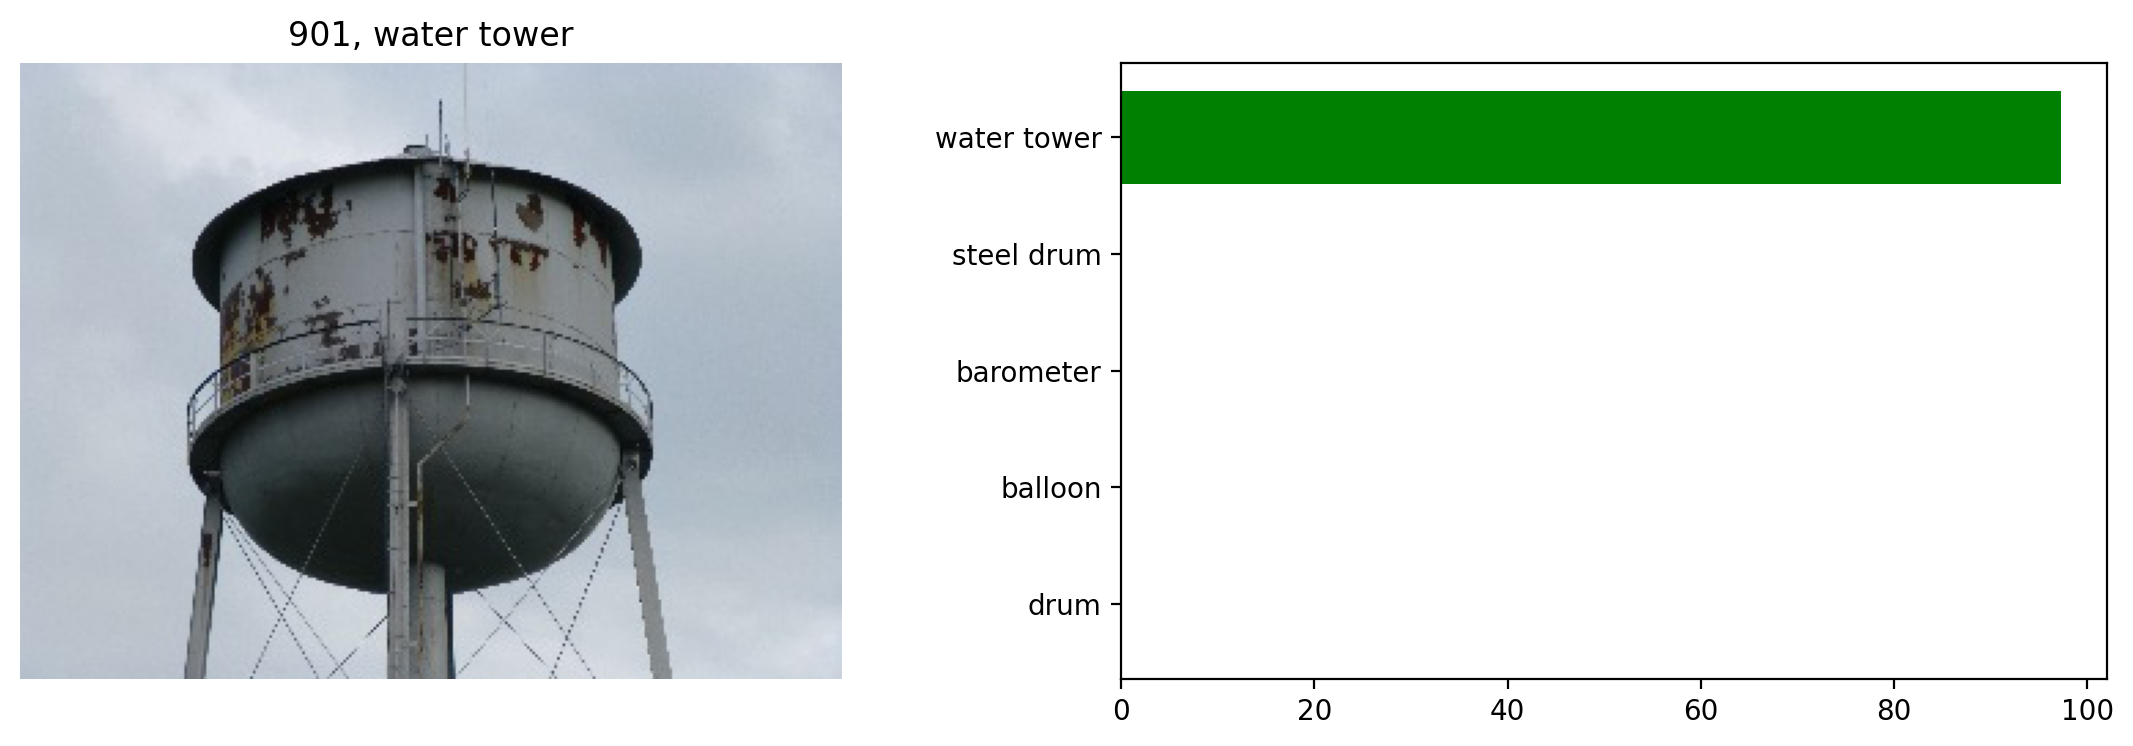

In [10]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.imshow(plt.imread(img))
idx = int(img.split('/')[-2]) + 1
plt.title(str(idx) + ', ' + label_text[idx])
plt.axis('off')

plt.subplot(1,2,2)
color = ['gray'] * 5
if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
color = color[::-1]
plt.barh(range(5), prediction[top_5_predict][::-1]*100, color=color)
plt.yticks(range(5), labels[::-1])

plt.show()

### 전이학습

In [11]:
import pandas as pd
label_text = pd.read_csv('./Downloads/dog_data/labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [12]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [13]:
label_text['breed'].nunique()

120

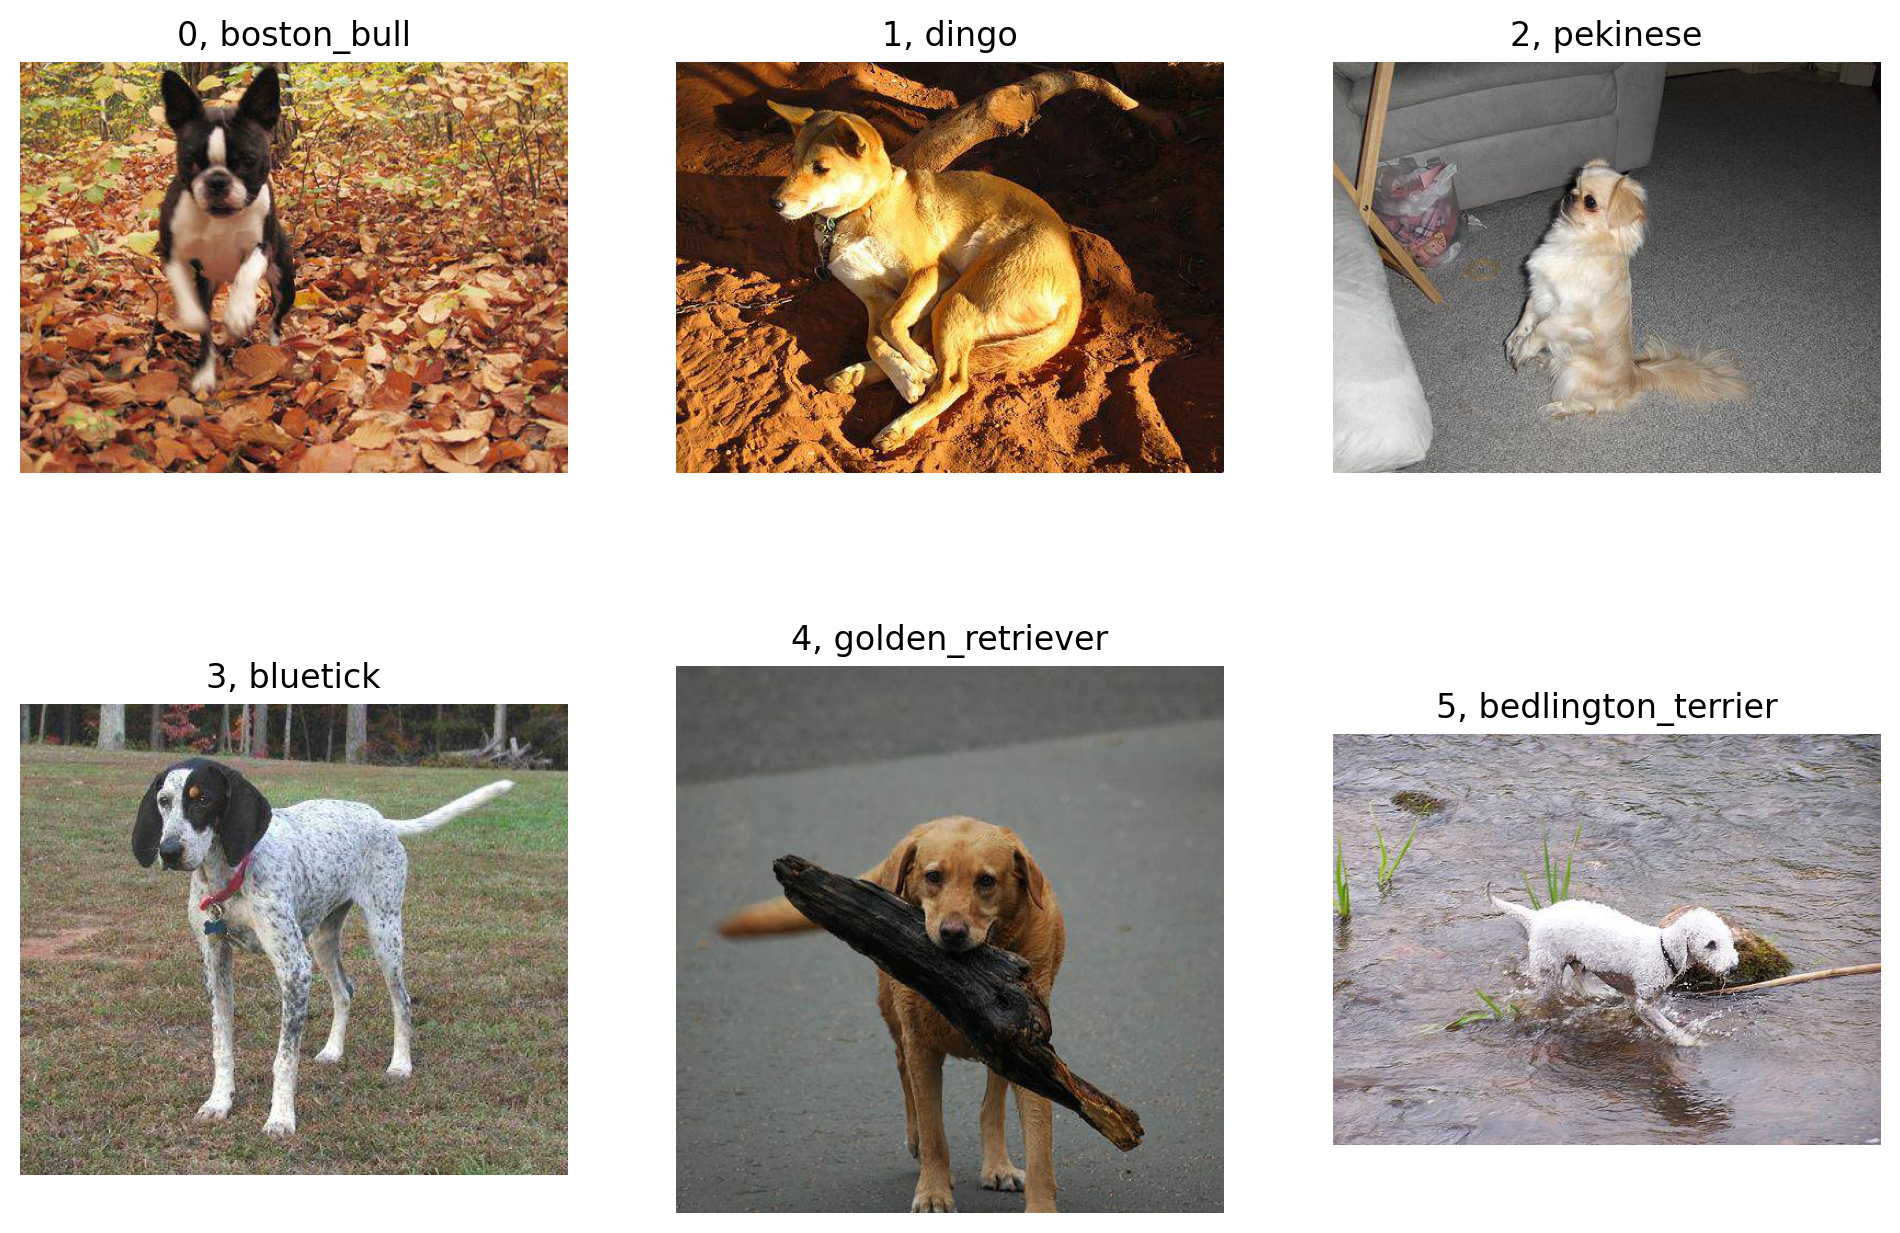

In [14]:
plt.figure(figsize=(12,8))
for c in range(6):
    image_id = label_text.loc[c, 'id']
    plt.subplot(2,3,c+1)
    plt.imshow(plt.imread('./Downloads/dog_data/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
    
plt.show()

In [15]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

In [16]:
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True
    
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [17]:
train_X = []
for i in range(len(label_text)):
    img = cv2.imread('./Downloads/dog_data/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224,224))
    img = img / 255.0
    train_X.append(img)
train_X = np.array(train_X)
print(train_X.shape)
print(train_X.size * train_X.itemsize, ' bytes')

(10222, 224, 224, 3)
12309577728  bytes


In [18]:
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[34 87 91 63 48  6 93 63 77 92]


In [19]:
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

Epoch 1/10
240/240 [==============================] - 258s 1s/step - loss: 3.9689 - accuracy: 0.1643 - val_loss: 1.9623 - val_accuracy: 0.4652
Epoch 2/10
240/240 [==============================] - 230s 958ms/step - loss: 1.7025 - accuracy: 0.6001 - val_loss: 1.5861 - val_accuracy: 0.5485
Epoch 3/10
240/240 [==============================] - 227s 946ms/step - loss: 1.2154 - accuracy: 0.7016 - val_loss: 1.4581 - val_accuracy: 0.5786
Epoch 4/10
240/240 [==============================] - 217s 905ms/step - loss: 0.9343 - accuracy: 0.7805 - val_loss: 1.4120 - val_accuracy: 0.5974
Epoch 5/10
240/240 [==============================] - 216s 900ms/step - loss: 0.7736 - accuracy: 0.8231 - val_loss: 1.3554 - val_accuracy: 0.6088
Epoch 6/10
240/240 [==============================] - 229s 957ms/step - loss: 0.6180 - accuracy: 0.8834 - val_loss: 1.3283 - val_accuracy: 0.6178
Epoch 7/10
240/240 [==============================] - 227s 947ms/step - loss: 0.5231 - accuracy: 0.9080 - val_loss: 1.3358 - va

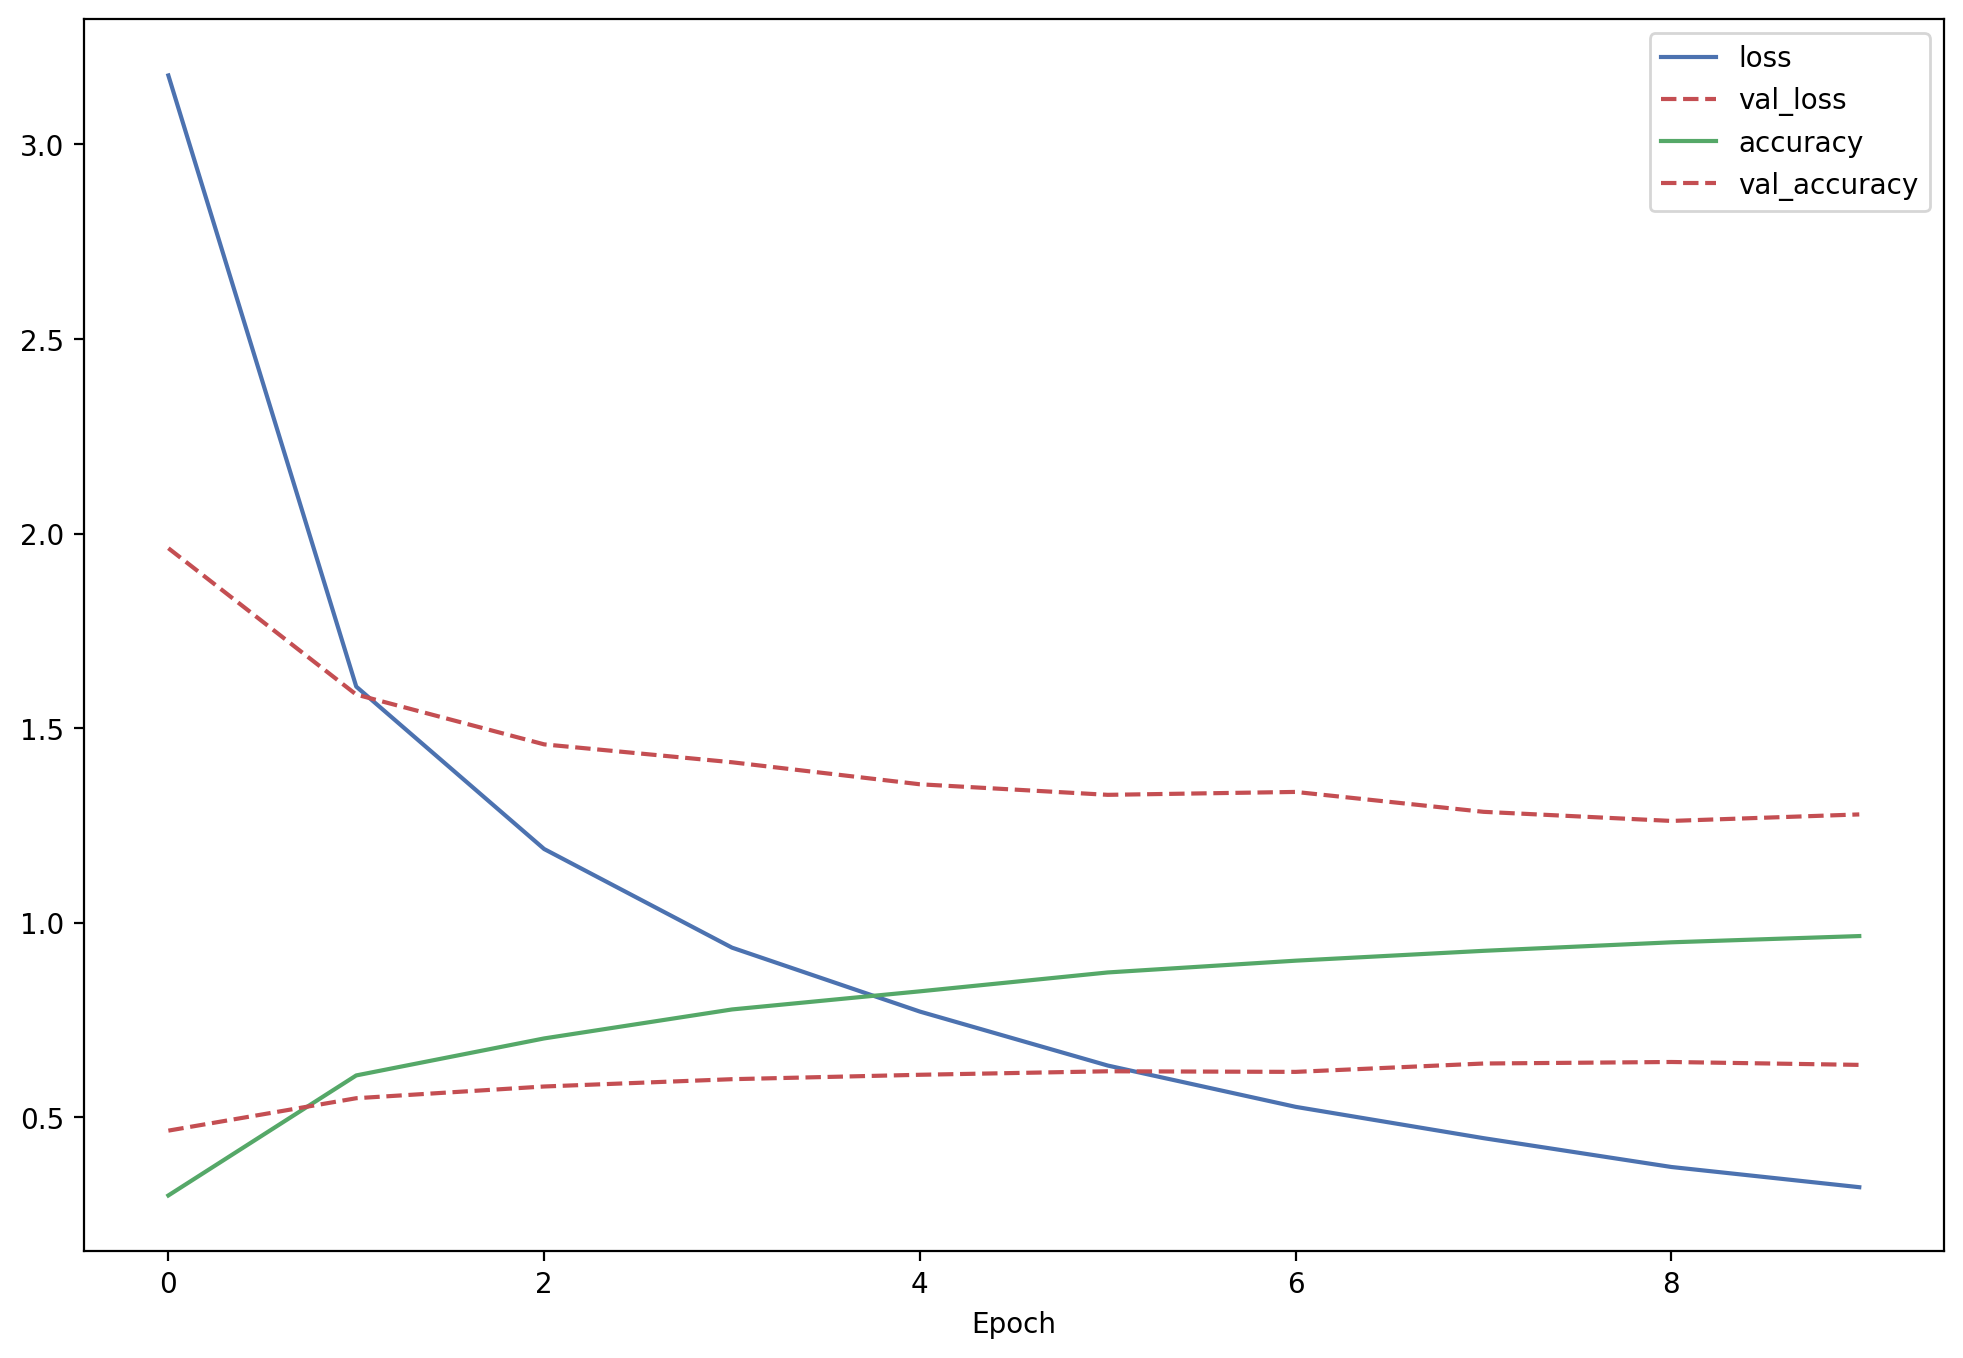

In [21]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [33]:
import tensorflow_hub as hub
import tensorflow as tf
inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [34]:
import os
import shutil

os.mkdir('./Downloads/train_sub')

for i in range(len(label_text)):
    if os.path.exists('./Downloads/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('./Downloads/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('./Downloads/dog_data/train/' + label_text.loc[i]['id'] +\
                '.jpg', './Downloads/train_sub/' + label_text.loc[i]['breed'])

In [35]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True,
                                   shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

In [36]:
train_generator = train_datagen.flow_from_directory(directory='./Downloads/train_sub/',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    seed=13,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory='./Downloads/train_sub/',
                                                    subset='validation', batch_size=1,
                                                    seed=13,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [37]:
batch_step = (7718 * 3) // batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0:
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)
    
    feature = feature_model.predict(x)
    train_features.extend(feature)
    
train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

0
100
200
300
400
500
600
700
(23084, 2048)
(23084, 120)


In [38]:
valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0:
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)
    
    feature = feature_model.predict(x)
    valid_features.extend(feature)
    
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(2048,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y),
                    epochs=10, batch_size=32)

Epoch 1/10
722/722 [==============================] - 4s 6ms/step - loss: 3.7595 - accuracy: 0.2534 - val_loss: 0.8613 - val_accuracy: 0.8734
Epoch 2/10
722/722 [==============================] - 4s 5ms/step - loss: 1.0661 - accuracy: 0.7596 - val_loss: 0.4124 - val_accuracy: 0.8938
Epoch 3/10
722/722 [==============================] - 4s 6ms/step - loss: 0.6476 - accuracy: 0.8238 - val_loss: 0.3384 - val_accuracy: 0.9050
Epoch 4/10
722/722 [==============================] - 4s 6ms/step - loss: 0.5262 - accuracy: 0.8464 - val_loss: 0.3161 - val_accuracy: 0.9058
Epoch 5/10
722/722 [==============================] - 4s 6ms/step - loss: 0.4609 - accuracy: 0.8585 - val_loss: 0.3076 - val_accuracy: 0.9042
Epoch 6/10
722/722 [==============================] - 4s 6ms/step - loss: 0.4215 - accuracy: 0.8666 - val_loss: 0.3051 - val_accuracy: 0.9062
Epoch 7/10
722/722 [==============================] - 4s 6ms/step - loss: 0.3768 - accuracy: 0.8868 - val_loss: 0.2952 - val_accuracy: 0.9069
Epoch 

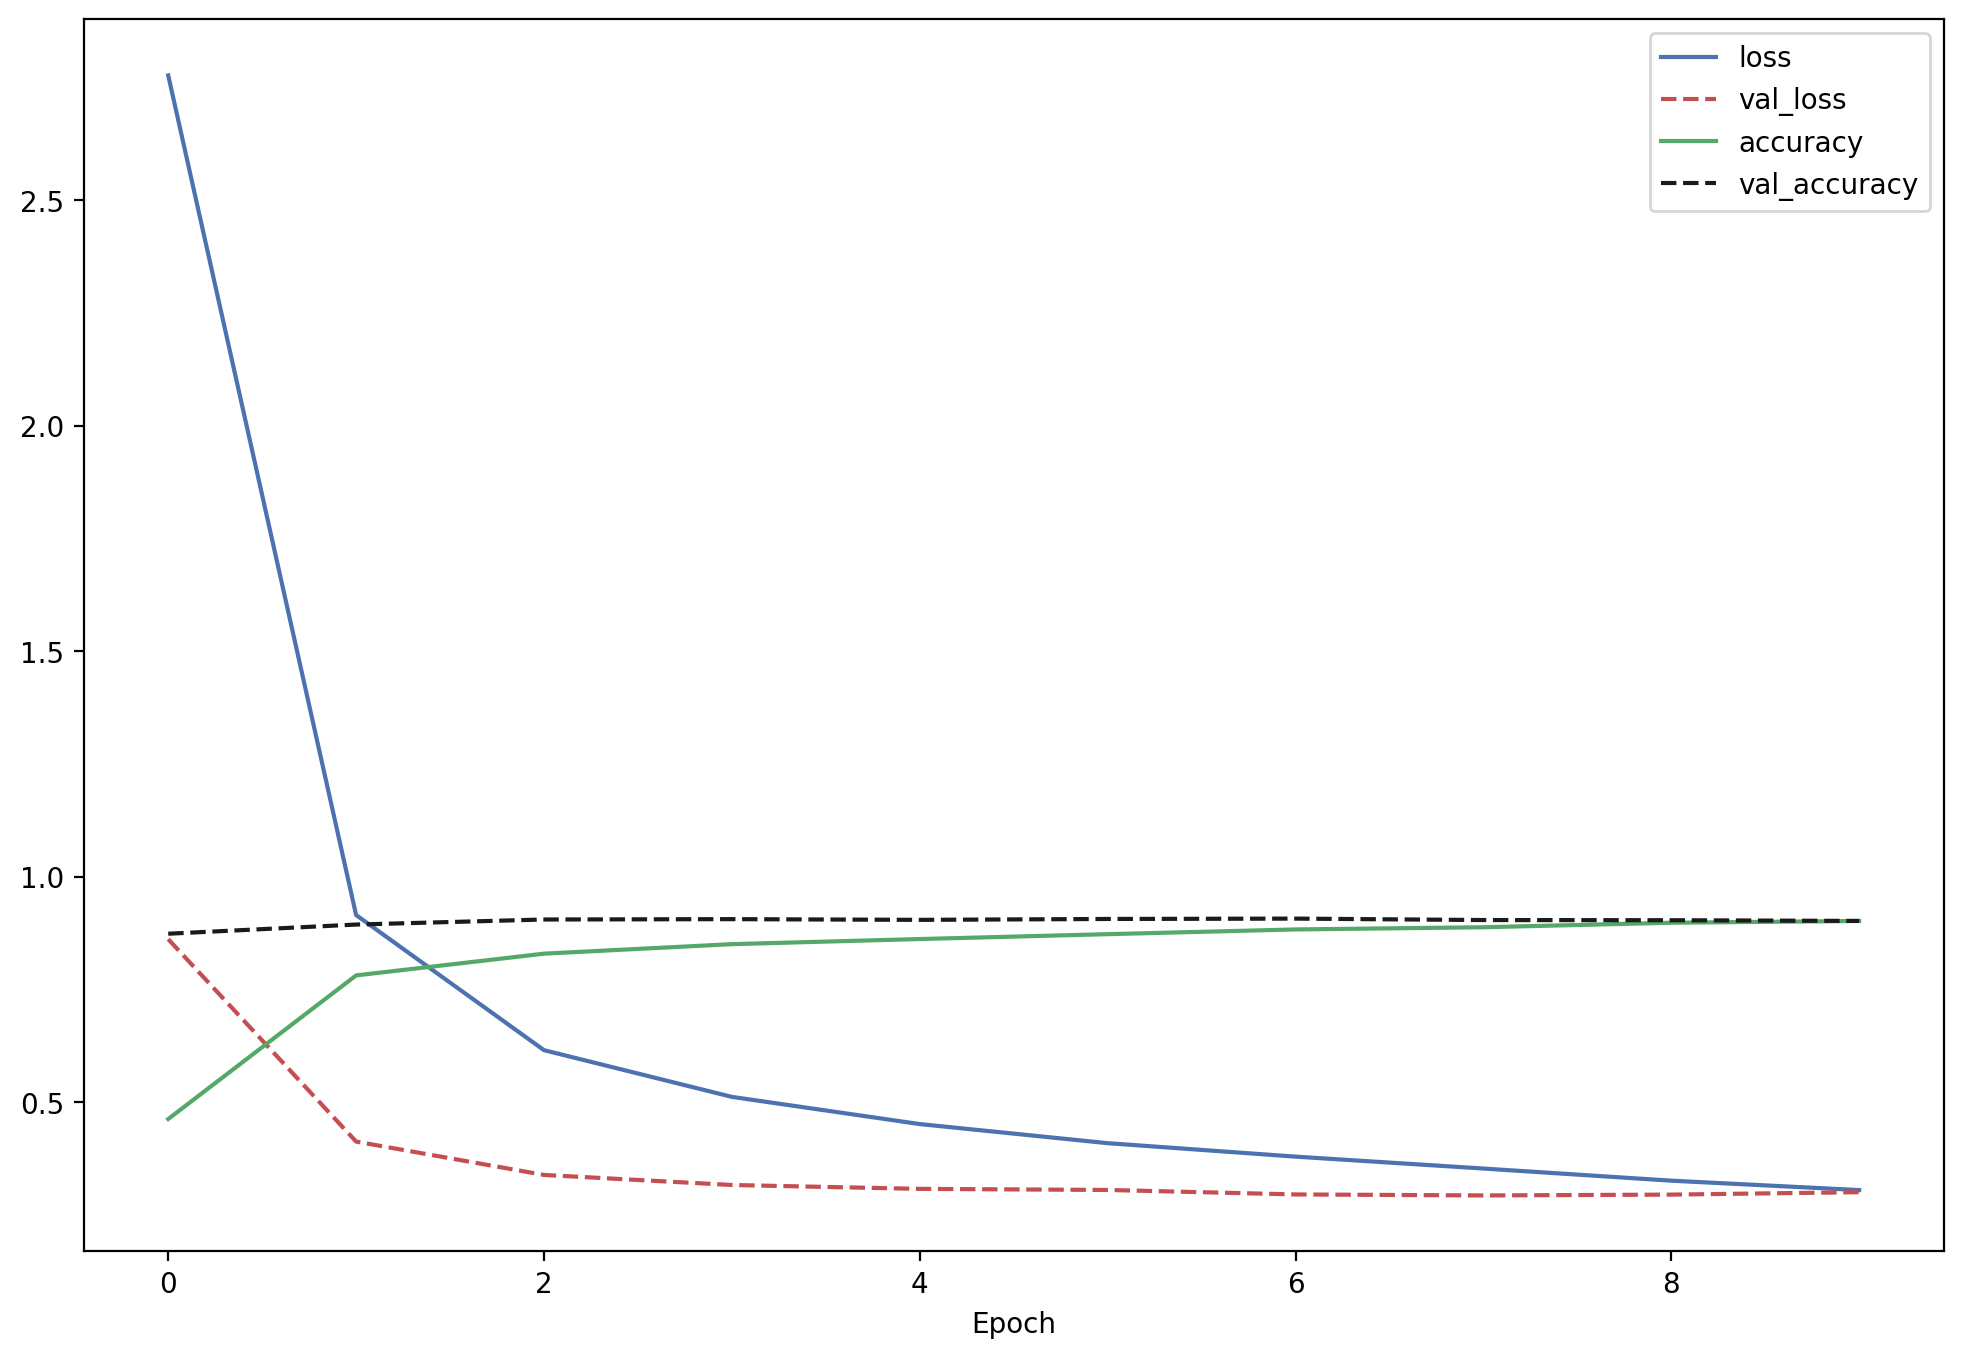

In [41]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [42]:
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [43]:
import random

image_path = random.choice(valid_generator.filepaths)
real_y = image_path.split('/')[2]
idx = unique_sorted_Y.index(real_y)

img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(299,299))
img = img / 255.0
img = np.expand_dims(img, axis=0)

feature_vector = feature_model.predict(img)

prediction = mopdel.predict(feature_vector)[0]

top_5_predict = prediction.argsort()[::-1][:5]
labels = [unique_sorted_Y[index] for index in top_5_predict]

ValueError: 'train_sub' is not in list

In [ ]:
print(top_5_predict)
print(labels)

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(plt.imread(image_path))
plt.title(real_y)
plt.axis('off')

plt.subplot(1,2,2)
color = ['gray'] * 5
if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
color = color[::-1]
plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
plt.yticks(range(5), labels[::-1])
plt.show()